# Test sur le dataset PTB

In [1]:
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [3]:
ptbdb_normal = pd.read_csv("../../Datascientest/Data/ptbdb_normal.csv", header=None)
ptbdb_abnormal = pd.read_csv("../../Datascientest/Data/ptbdb_abnormal.csv", header=None)

ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal]).sample(frac=1).reset_index(drop=True)
X_ptb = ptbdb.iloc[:,:-1]
y_ptb = ptbdb.iloc[:,-1]
y_ptb = to_categorical(y_ptb)

In [6]:
CNN_1 = keras.models.load_model("../models/CNN_1")

In [7]:
CNN_predict_ptb = CNN_1.predict(X_ptb).argmax(1)

In [8]:
CNN_predict_ptb = np.where((CNN_predict_ptb == 2)|(CNN_predict_ptb == 3)|(CNN_predict_ptb == 4), 1, CNN_predict_ptb)

In [9]:
CNN_predict_ptb = pd.Series(CNN_predict_ptb)

In [10]:
y_ptb = pd.Series(y_ptb.argmax(1))

In [11]:
pd.crosstab(y_ptb, CNN_predict_ptb, rownames = ["reel"], colnames= ["predict"]) 

predict,0,1
reel,,
0,3878,168
1,9098,1408


In [12]:
print(classification_report(y_ptb, CNN_predict_ptb))

              precision    recall  f1-score   support

           0       0.30      0.96      0.46      4046
           1       0.89      0.13      0.23     10506

    accuracy                           0.36     14552
   macro avg       0.60      0.55      0.34     14552
weighted avg       0.73      0.36      0.29     14552



Lorsqu'on teste le modèle tel quel, nous observons un très mauvais rappel. Regardons des exemples d'ECG bien classés et mal classés afin de voir si on trouve des patterns.

In [13]:
CNN_output_ptb = pd.concat([y_ptb, CNN_predict_ptb], axis=1)
CNN_output_ptb.columns = ["reel", "predict_CNN"]

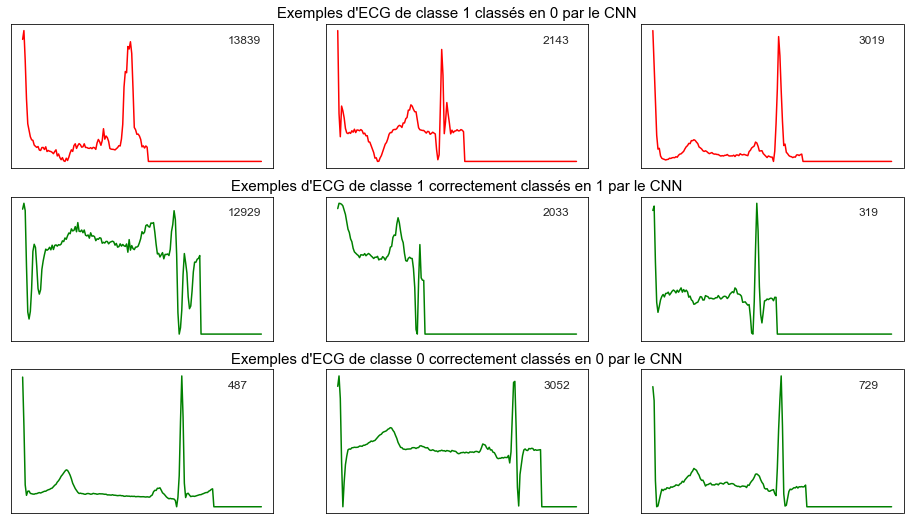

In [14]:
fig,ax = plt.subplots(3,3, figsize = (16,9)) 
sns.set_theme()

for i in range(3): 
    indice_0 = choice(CNN_output_ptb[(CNN_output_ptb["reel"] == 1) & (CNN_output_ptb["predict_CNN"] == 0)].index) 
    ax[0,i].plot(X_ptb.iloc[indice_0], c="red")
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    ax[0,1].set_title("Exemples d'ECG de classe 1 classés en 0 par le CNN", fontsize = 15)
    ax[0,i].text(160, 0.9, indice_0)
    
for i in range(3): 
    indice_1 = choice(CNN_output_ptb[(CNN_output_ptb["reel"] == 1) & (CNN_output_ptb["predict_CNN"] == 1)].index) 
    ax[1,i].plot(X_ptb.iloc[indice_1], c="green")
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    ax[1,1].set_title("Exemples d'ECG de classe 1 correctement classés en 1 par le CNN", fontsize = 15)
    ax[1,i].text(160, 0.9, indice_1)
    
for i in range(3): 
    indice_2 = choice(CNN_output_ptb[(CNN_output_ptb["reel"] == 0) & (CNN_output_ptb["predict_CNN"] == 0)].index) 
    ax[2,i].plot(X_ptb.iloc[indice_2], c="green")
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    ax[2,1].set_title("Exemples d'ECG de classe 0 correctement classés en 0 par le CNN", fontsize = 15)
    ax[2,i].text(160, 0.9, indice_2)

## Transfert Learning à partir du modèle du CNN entrainé sur le dataset MIT

### Remplacement de la dernière couche de classification

Nous allons remplacer la dernière couche de classification à 5 neurones par une couche à 2 neurones, puis nous allons entrainer la dernière couche avec une partie du dataset PTB.

In [15]:
for layer in CNN_1.layers:
    layer.trainable = False
    
output = Dense(units = 2, activation="softmax", name="output2" )(CNN_1.layers[-2].output)

CNN_2 = Model(inputs = CNN_1.input, outputs = output)
CNN_2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])


In [16]:
CNN_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 183, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 91, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 91, 32)            0         
                                                                 
 flatten (Flatten)           (None, 2912)              0         
                                                                 
 dense (Dense)               (None, 128)               372864    
                                                             

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ptb, y_ptb, test_size = 0.2)

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
CNN_2.fit(X_train, y_train, epochs = 10, batch_size = 200, validation_split = 0.2)

Epoch 1/10
47/47 [==============================] - 2s 25ms/step - loss: 0.6770 - accuracy: 0.6799 - val_loss: 0.5837 - val_accuracy: 0.7055
Epoch 2/10
47/47 [==============================] - 1s 21ms/step - loss: 0.5554 - accuracy: 0.7117 - val_loss: 0.5169 - val_accuracy: 0.7389
Epoch 3/10
47/47 [==============================] - 1s 20ms/step - loss: 0.5058 - accuracy: 0.7381 - val_loss: 0.4835 - val_accuracy: 0.7570
Epoch 4/10
47/47 [==============================] - 1s 19ms/step - loss: 0.4773 - accuracy: 0.7599 - val_loss: 0.4629 - val_accuracy: 0.7767
Epoch 5/10
47/47 [==============================] - 1s 17ms/step - loss: 0.4598 - accuracy: 0.7738 - val_loss: 0.4498 - val_accuracy: 0.7879
Epoch 6/10
47/47 [==============================] - 1s 17ms/step - loss: 0.4498 - accuracy: 0.7785 - val_loss: 0.4413 - val_accuracy: 0.7918
Epoch 7/10
47/47 [==============================] - 1s 17ms/step - loss: 0.4435 - accuracy: 0.7821 - val_loss: 0.4338 - val_accuracy: 0.7982
Epoch 8/10
47

In [21]:
CNN_2_predict = CNN_2.predict(X_test).argmax(1)

In [22]:
pd.crosstab(y_test.argmax(1), CNN_2_predict)

col_0,0,1
row_0,,
0,492,349
1,259,1811


In [23]:
print(classification_report(y_test.argmax(1), CNN_2_predict))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       841
           1       0.84      0.87      0.86      2070

    accuracy                           0.79      2911
   macro avg       0.75      0.73      0.74      2911
weighted avg       0.79      0.79      0.79      2911



Nous observons déjà de meilleurs résultats en terme de rappel. Par contre on a  un déséquilibre des classes donc procédons à un oversampling SMOTE :

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm = to_categorical(y_sm)

In [45]:
CNN_2.fit(X_sm, y_sm, epochs = 30, batch_size = 200, validation_split = 0.2)
CNN_2_predict_sm = CNN_2.predict(X_test).argmax(1)

Epoch 1/30
68/68 [==============================] - 1s 13ms/step - loss: 0.4508 - accuracy: 0.7737 - val_loss: 0.5472 - val_accuracy: 0.7407
Epoch 2/30
68/68 [==============================] - 1s 13ms/step - loss: 0.4497 - accuracy: 0.7751 - val_loss: 0.5441 - val_accuracy: 0.7428
Epoch 3/30
68/68 [==============================] - 1s 13ms/step - loss: 0.4487 - accuracy: 0.7744 - val_loss: 0.6069 - val_accuracy: 0.7049
Epoch 4/30
68/68 [==============================] - 1s 15ms/step - loss: 0.4486 - accuracy: 0.7757 - val_loss: 0.6085 - val_accuracy: 0.7061
Epoch 5/30
68/68 [==============================] - 1s 12ms/step - loss: 0.4479 - accuracy: 0.7770 - val_loss: 0.5811 - val_accuracy: 0.7185
Epoch 6/30
68/68 [==============================] - 1s 12ms/step - loss: 0.4489 - accuracy: 0.7732 - val_loss: 0.6209 - val_accuracy: 0.6975
Epoch 7/30
68/68 [==============================] - 1s 12ms/step - loss: 0.4476 - accuracy: 0.7740 - val_loss: 0.6051 - val_accuracy: 0.7046
Epoch 8/30
68

In [46]:
pd.crosstab(y_test.argmax(1), CNN_2_predict_sm)

col_0,0,1
row_0,,
0,622,219
1,445,1625


In [47]:
print(classification_report(y_test.argmax(1), CNN_2_predict_sm))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       841
           1       0.88      0.79      0.83      2070

    accuracy                           0.77      2911
   macro avg       0.73      0.76      0.74      2911
weighted avg       0.80      0.77      0.78      2911



Après rééquilbrage des classes avant entrainement de la dernière couche, on observe de meilleurs résultats. Au lieu de simplement modifier la dernière couche, nous allons remplacer la dernière couche par 2 couches.

### Remplacement des deux dernières couches de classification

In [30]:
CNN_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 183, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 91, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 91, 32)            0         
                                                                 
 flatten (Flatten)           (None, 2912)              0         
                                                                 
 dense (Dense)               (None, 128)               372864    
                                                           

In [32]:
dense_5 = Dense(units = 128, activation = "tanh", name = "dense5", kernel_initializer="normal")(CNN_1.layers[-2].output)
output = Dense(units = 2, activation="softmax", name="output2" )(dense_5)
CNN_3 = Model(inputs = CNN_1.inputs, outputs = output)
CNN_3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [33]:
CNN_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 183, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 91, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 91, 32)            0         
                                                                 
 flatten (Flatten)           (None, 2912)              0         
                                                                 
 dense (Dense)               (None, 128)               372864    
                                                           

In [42]:
CNN_3.fit(X_sm, y_sm, epochs = 30, batch_size = 200, validation_split = 0.2)
CNN_3_predict_sm = CNN_3.predict(X_test).argmax(1)

Epoch 1/30
68/68 [==============================] - 1s 13ms/step - loss: 0.2028 - accuracy: 0.9210 - val_loss: 0.1932 - val_accuracy: 0.9440
Epoch 2/30
68/68 [==============================] - 1s 13ms/step - loss: 0.1955 - accuracy: 0.9226 - val_loss: 0.1660 - val_accuracy: 0.9579
Epoch 3/30
68/68 [==============================] - 1s 13ms/step - loss: 0.1909 - accuracy: 0.9276 - val_loss: 0.1544 - val_accuracy: 0.9597
Epoch 4/30
68/68 [==============================] - 1s 13ms/step - loss: 0.1914 - accuracy: 0.9234 - val_loss: 0.1841 - val_accuracy: 0.9470
Epoch 5/30
68/68 [==============================] - 1s 13ms/step - loss: 0.1895 - accuracy: 0.9250 - val_loss: 0.2346 - val_accuracy: 0.9191
Epoch 6/30
68/68 [==============================] - 1s 14ms/step - loss: 0.1868 - accuracy: 0.9258 - val_loss: 0.0959 - val_accuracy: 0.9801
Epoch 7/30
68/68 [==============================] - 1s 14ms/step - loss: 0.1886 - accuracy: 0.9245 - val_loss: 0.0968 - val_accuracy: 0.9778
Epoch 8/30
68

In [43]:
pd.crosstab(y_test.argmax(1), CNN_3_predict_sm)

col_0,0,1
row_0,,
0,790,51
1,107,1963


In [44]:
print(classification_report(y_test.argmax(1), CNN_3_predict_sm))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       841
           1       0.97      0.95      0.96      2070

    accuracy                           0.95      2911
   macro avg       0.93      0.94      0.94      2911
weighted avg       0.95      0.95      0.95      2911



Nous observons de meilleurs résultats qu'avec le réseau de neurones précédent.